In [2]:

import numpy as np
from pathlib import Path
from scipy.spatial.transform import Rotation
import deepdrr
from deepdrr import geo
from deepdrr.utils import test_utils
from PIL import Image
import pytest
import copy
import time
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
from pathlib import Path
import io
from matplotlib import pyplot as plt

from deepdrr.utils.img_cmp import verify_image
from deepdrr.utils.image_utils import ensure_cdim, as_uint8, as_float32
import cv2
import seaborn as sns


import pyvista as pv
import logging
import pyrender
from deepdrr.pyrenderdrr.material import DRRMaterial
from deepdrr.utils.mesh_utils import *


import logging
import numpy as np
from pathlib import Path
import nibabel as nib
from pydicom.filereader import dcmread
import nrrd
from scipy.spatial.transform import Rotation
from scipy.interpolate import RegularGridInterpolator
import trimesh
import pyvista as pv

from datetime import datetime
from typing import Tuple

from pydantic import BaseModel

In [3]:
path = test_utils.download_sampledata("CT-chest")
# print file size in mb
print(path.stat().st_size / 1e6)

Using downloaded and verified file: /home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd
42.189103


In [69]:
hu_values, header = nrrd.read(path)
hu_values.shape

(512, 512, 139)

In [20]:
import h5py

def load_func():
    with h5py.File("hu_values.h5", "w") as f:
        # f.create_dataset("hu_values", data=hu_values, compression="gzip", compression_opts=1)
        # f.create_dataset("hu_values", data=hu_values)
        f.create_dataset("hu_values", data=hu_values, compression="lzf")


%timeit -r2 load_func()


832 ms ± 15.6 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)


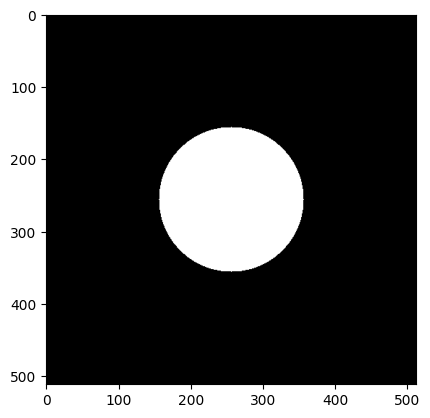

In [23]:
# make np array with white circle in the middle

im = np.zeros((512, 512), dtype=np.uint8)

# draw circle
cv2.circle(im, (256, 256), 100, 255, -1)

# show im
plt.imshow(im, cmap="gray")
plt.show()

In [26]:
!pip install pycocotools

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (426 kB)


In [32]:
import deepdrr.coco_utils as coco_utils

def time_func():
    for i in range(100):
        for j in range(50):
            s = coco_utils.encode_segmentation(im)

%time time_func()




CPU times: user 1.46 s, sys: 0 ns, total: 1.46 s
Wall time: 1.46 s


In [36]:
%timeit coco_utils.encode_segmentation(im)

293 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
s = coco_utils.encode_segmentation(im)
len(s["counts"])


414

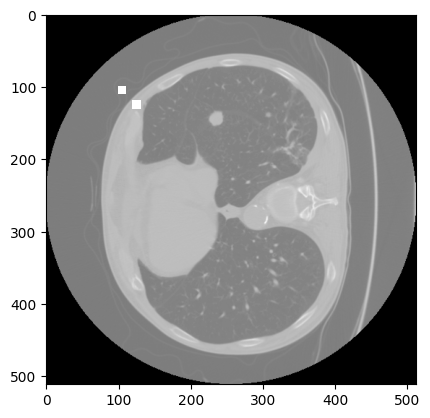

In [45]:
safd = hu_values[:,:,50].astype(np.float32)

# add a nan square
safd[100:110, 100:110] = np.nan

# add a inf square
safd[120:130, 120:130] = np.inf

plt.imshow(safd, cmap="gray")


In [46]:
from deepdrr.utils import image_utils, neglog

%timeit image_utils.save_raw("hu_values.tiff", safd)

2.41 ms ± 77.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
# load the tiff with pil

im = Image.open("hu_values.tiff")

# convert to numpy array
im = np.array(im)

# im should be the same as safd
np.allclose(im, safd, equal_nan=True)

True

In [68]:
from tiffinspector import TiffInspector

# Instantiate the TiffInspector with the path to the TIFF file
tiff_inspector = TiffInspector("hu_values.tiff")

# Display the report
tiff_inspector.display_report(expanded=False, levels=None, max_text_length=None)

## Series 1 of 1

### Level 1 of 1

#### Page 1 of 1

**description:**
None

name,dtype,valueoffset,count,value
ImageWidth,DATATYPE.LONG,18,1,512
ImageLength,DATATYPE.LONG,30,1,512
BitsPerSample,DATATYPE.SHORT,42,1,32
Compression,DATATYPE.SHORT,54,1,COMPRESSION.NONE
PhotometricInterpretation,DATATYPE.SHORT,66,1,PHOTOMETRIC.MINISBLACK
StripOffsets,DATATYPE.LONG,78,1,[134]
RowsPerStrip,DATATYPE.LONG,90,1,512
StripByteCounts,DATATYPE.LONG,102,1,[1048576]
PlanarConfiguration,DATATYPE.SHORT,114,1,PLANARCONFIG.CONTIG
SampleFormat,DATATYPE.SHORT,126,1,SAMPLEFORMAT.IEEEFP


#### Frames: 0

[]

In [76]:
import numpy as np
from skimage.io import tifffile as tif

a = np.random.randint(0,5, size=(100,100,100))
a = a.astype('int8')
tif.imsave('a.tif', a, bigtiff=True)

ImportError: cannot import name 'tifffile' from 'skimage.io' (/home/pelvisvr/mambaforge/envs/deepdrr/lib/python3.10/site-packages/skimage/io/__init__.py)

In [43]:
%timeit np.savez("hu_values.npy", safd)

2.8 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
# save with npz

def load_func():
    np.savez("hu_values.npz", hu_values=hu_values)

%timeit -r1 load_func()

302 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
# save with npy

def load_func():
    np.save("hu_values.npy", hu_values)

%timeit -r1 load_func()

128 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [15]:
# save with nrrd

def load_func():
    nrrd.write("hu_values.nrrd", hu_values)

%time load_func()

KeyboardInterrupt: 

In [16]:
# save with nii
import nibabel as nib

def load_func():
    nib.save(nib.Nifti1Image(hu_values, np.eye(4)), "hu_values.nii")

%timeit -r1 load_func()

199 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [ ]:

# def load_func():
#     with h5py.File("hu_values.h5", "r") as f:
#         a = f["hu_values"][:]
#     return a[0, 0, 0]

# %timeit load_func()

In [ ]:
volume = Volume.from_nrrd("hu_values.nrrd")
mesh1 = Mesh.from_stl("mesh1.stl", tag="mesh1")
mesh2 = Mesh.from_stl("mesh2.stl", tag="mesh2")

carm = MobileCArm()

graph = TransformGraph()
graph.add(carm)
graph.add(volume)
graph.add(mesh1)
graph.add(mesh2)

scene = GraphScene(graph)

renderer1 = SynchronousRenderer(scene=scene)

drr_settings = DRRRenderSettings(
    width=512,
    height=512,
    neglog=True,
)
drr_prof = DRRRenderProfile(
    settings=drr_settings,
    renderer=renderer1
)

renderer2 = SynchronousRenderer(scene=scene)

rast_settings = RasterizeRenderSettings(
    width=512,
    height=512,
    max_mesh_hits=32,
)
rasterize_prof = RasterizeRenderProfile(
    settings=rast_settings,
    renderer=renderer2
)

mesh1.world_from_anatomical = geo.FrameTransform.from_translation([-30, 50, 200])

for frame_idx in range(10):
    mesh2.world_from_anatomical = geo.FrameTransform.from_translation([0, 0, 10*frame_idx])

    carm.move_by(
        delta_isocenter=[0, 0, 10],
        delta_alpha=5*frame_idx,
        delta_beta=0,
        delta_gamma=0,
        degrees=False,
    )

    drr = drr_prof.render_drr()

    segs = rasterize_prof.render_seg()
    hits = rasterize_prof.render_hits()


    

In [ ]:
a = Primitive(primitive_id="a", data=StlMesh(url="file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd", material_name="material_name", density=1.0, priority=1, addtive=True, subtractive=True))
b = Primitive(primitive_id="b", data=H5Volume(url="file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd", priority=1))

cam = Camera(transform=Matrix4x4(data=np.eye(4).flatten()), intrinsic=CameraIntrinsic(fx=1.0, fy=1.0, cx=0.0, cy=0.0, near=1.0, far=100.0))
inst = Instance(primitive_id="a", transform=Matrix4x4(data=np.eye(4).flatten()), morph_weights=[1.0, 2.0, 3.0])
frame = Frame(camera=cam, instances=[inst])

In [ ]:
c = Scene(primitives=[a,b], frames=[frame])

In [ ]:
# save to asdf.json

with open("asdf.json", "w") as f:
    f.write(c.model_dump_json(indent=2))

In [ ]:
# load
with open("asdf.json", "r") as f:
    d = Scene.model_validate_json(f.read())

d

Scene(primitives=[Primitive(primitive_id='a', data=StlMesh(prim_data_type='StlMesh', url=Url('file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd'), material_name='material_name', density=1.0, priority=1, addtive=True, subtractive=True)), Primitive(primitive_id='b', data=H5Volume(prim_data_type='H5Volume', url=Url('file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd'), priority=1))], frames=[Frame(camera=Camera(transform=Matrix4x4(data=[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]), intrinsic=CameraIntrinsic(fx=1.0, fy=1.0, cx=0.0, cy=0.0, near=1.0, far=100.0)), instances=[Instance(primitive_id='a', transform=Matrix4x4(data=[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]), morph_weights=[1.0, 2.0, 3.0])])])

In [ ]:
a.data.url.path

'/home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd'

In [ ]:
import urllib.request

o = urllib.request.urlopen("file:///home/pelvisvr/datasets/DeepDRR_DATA/CT-chest.nrrd")

asdf = o.read()

print(len(asdf) / 1e6)

42.189103


In [ ]:
type(asdf)

bytes